![Practicum AI Logo image](https://github.com/PracticumAI/practicumai.github.io/blob/main/images/logo/PracticumAI_logo_250x50.png?raw=true) <img src='https://github.com/PracticumAI/deep_learning/blob/main/images/practicumai_deep_learning.png?raw=true' alt='Practicum AI: Deep Learning Foundations icon' align='right' width=50>
***

# Computer Vision Concepts

You may recall *Practicum AI*'s heroine Amelia, the AI-savvy nutritionist. At the end of our [Deep Learning Foundations course](https://practicumai.org/courses/deep_learning/), Amelia was helping with a computer vision project. Her colleague, an entomologist named Kevin, had a dataset of images of bees and wasps and wanted to classify them.

![Image of bees and wasps from the dataset cover image](https://github.com/PracticumAI/deep_learning/blob/main/images/bees_wasps_dataset-cover.png?raw=true)

Well, Kevin needs more help. At the end of the Deep Learning Foundations course, we had explored the data, trained a model, and explored some hyperparameter tuning. However, several issues remained unresolved with the project.

* First, we didn’t fully explore the details of how convolutional neural networks function. 
   * We will provide more information as we go back through the steps in this notebook.
* Second, most of our models were overfitting—performing better on the training data than they did on the testing data. Essentially, the models memorized the training data but did not generalize well to new data that had not been seen. 
   * In this notebook, we will explore **dropout** as one mechanism to mitigate overfitting.
* Third, as you experimented with different hyperparameters, you may have lost track of what changes helped or hurt your model. You may have had trouble keeping track of the changes you made.
   * In this notebook, we introduce you to [TensorBoard](https://www.tensorflow.org/tensorboard), one popular tool in a class of tools known as **experiment tracking** or **MLOps tools**. These tools help track changes to hyperparameters and the training logs from those as well as the training data. They allow comparison among runs and can even automate multiple runs for you. Learning to use MLOps tools will help you as you continue to learn more about AI workflows.
* And lastly, one of the fundamental issues we encountered with the dataset was the imbalance of classes—There are way more images of some classes than others. 
   * This is a common issue with real data, and in notebook [01.2_stratification.ipynb](01.2_stratification.ipynb), we will explore some methods to handle this.
 
If you need a refresher, or haven't taken the Deep Learning Foundations course, the final notebook is part of this repository: [DLF_03_bees_vs_wasps.ipynb](DLF_03_bees_vs_wasps.ipynb).



## 1. Import the libraries we will use

In [1]:
import tensorflow as tf   # Import the TensorFlow library, which provides tools for deep learning.
import pandas as pd  # Import the pandas library, used for data manipulation and analysis.
import datetime

# Used for data management
import requests
import os
import time
import tarfile

import matplotlib.pyplot as plt  # Import the matplotlib library for plotting and visualization.

 
# Import Keras libraries
from tensorflow.keras.models import Sequential  # Import the Sequential model: a linear stack of layers from Keras module in TensorFlow.
from tensorflow.keras.layers import Dense  # Import the Dense layer: a fully connected neural network layer from Keras module in TensorFlow.
from tensorflow.keras.layers import Flatten  # Import the Flatten layer: used to convert input data into a 1D array from Keras module in TensorFlow.
from tensorflow.keras.losses import SparseCategoricalCrossentropy  # Import the SparseCategoricalCrossentropy loss function from Keras module in TensorFlow.
from tensorflow.keras import layers 
from tensorflow.keras import losses
from sklearn.metrics import confusion_matrix 
import numpy as np 

# Import helper functions--most of these were in the cells of the DLF_03_bees_vs_wasps.ipynb notebook.
# We moved them out of the notebook to enhace readability. 
import helpers_01

## Jupyter magic commands

In Jupyter, the `%` is used as a "magic" command. These extend Python on various ways. In this case, Tensorboad functionality is added using `%load_ext tensorboard`


In [2]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

## 2. Getting the data

Check the "Getting the data" section of [DLF_03_bees_vs_wasps.ipynb](DLF_03_bees_vs_wasps.ipynb#2.-Getting-the-data) for details about the dataset and the code used to getting the data if neede. Or you can look at the [helpers_01.py file](helpers_01.py). 

If you need to download the data, it is [hosted for download from Dropbox here as a `tar.gz` file](https://www.dropbox.com/s/x70hm8mxqhe7fa6/bee_vs_wasp.tar.gz?dl=0). If you need to manually extract the data, you can add a cell and run: `helpers_01.extract_file("bee_vs_wasp.tar.gz", "data")`


In [3]:
# Check for the data.
# This will look for the data files required for this notebook in some common locations.
# If it can't find the data, it will ask if you know where it is. If you do, answer yes and 
# provide the path to the data (up to and including the `bee_vs_wasp` folder name). If not, 
# it will ask if you want to download it. If you answer yes, it will download the data and 
# extract it into your data folder.""

data_path = helpers_01.manage_data()    

Found data at /blue/practicum-ai/share/data/bee_vs_wasp.


## 3. Examine some images

Many of the steps in this notebook are written as functions, making it easier to run these steps repeatedly as you work on optimizing the various hyperparameters.


***********************************************************************
Load data:
  - Loading the dataset from: /blue/practicum-ai/share/data/bee_vs_wasp.
  - Using a batch size of: 32.
  - Resizing input images to: (80, 80, 3).
***********************************************************************
Found 11422 files belonging to 4 classes.
Using 9138 files for training.


2024-05-21 09:26:46.470626: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-21 09:26:47.204490: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 78902 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:b7:00.0, compute capability: 8.0


Found 11422 files belonging to 4 classes.
Using 2284 files for validation.
['bee', 'other_insect', 'other_noinsect', 'wasp']


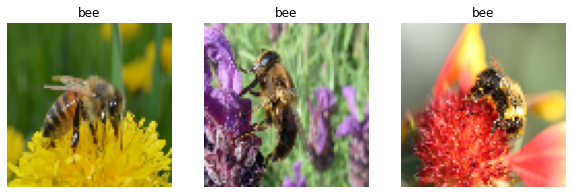

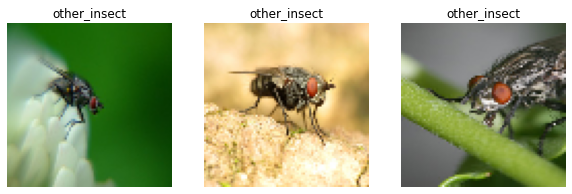

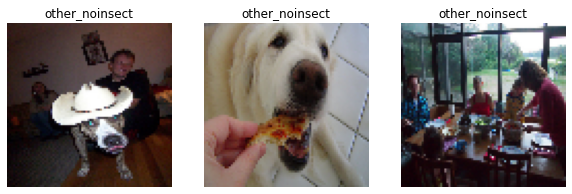

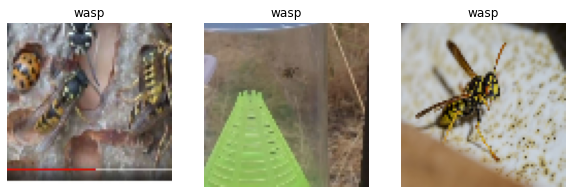

In [4]:
# The data path should be set from the cell above. 
# If that failed and you want to set it manually, use the line below.
# data_path= "data/bee_vs_wasp"

X_train, X_test = helpers_01.load_display_data(data_path, batch_size=32, shape=(80,80,3), show_pictures=True)


## Set hyperparameters

In [5]:
#data_path = 'data/bee_vs_wasp/' # Path to the data.
        # This is defined above, you only need to change this if you change datasets
    
show_pictures = False # We'll turn this off, but change to True if you want them...

# Hyperparameters
shape = (80,80,3)  # Dimensions to use for the images...the raw data are 80x80
                   #  color images, but you could down-sample them
                   #  or convert them to black and white if you wanted
batch_size = 32  # What batch size to use
classes = 4 # We have 4 classes in our dataset: bee, wasp, other_insect, other_noninsect
            # Only change this if you change the dataset
activation='relu' # The activation function is an important hyperparameter
                  # Other activations functions to try: tanh, sigmoid

loss=SparseCategoricalCrossentropy(from_logits=True) # Loss function
        # Other loss functions to try: losses.CategoricalHinge()
        #                              losses.KLDivergence()

optimizer='Adagrad' # Optimizer: Adagrad is just an example, others to try are Adam or RMSprop

learning_rate=0.001 # Try increasing or decreasing the learning rate by an order of magnitude

epochs = 10 # Try running more epochs


## 4. Make our model

This function creates the model we will use.

One hyperparameter to explore is the activation function, which is set when making the model. We start with a ReLU as the default, but you can try others. For simplicity, we will use the same activation function for all but the last layer of the model, but you could change them individually.

The last layer will almost always use a Softmax, which makes all the output values between 0 and 1 and sum to 1, transforming them into probabilities of the input belonging to each possible class.

In [6]:
def make_model(activation='relu', shape=(80,80,3), num_classes=4):
    '''Sets up a model. 
          Takes in an activation function, shape for the input images, and number of classes.
          Returns the model.'''
    print("***********************************************************************")
    print("Make model:")
    print(f"  - Using the activation function: {activation}.")
    print(f"  - Model will have {num_classes} classes.")
    print("***********************************************************************")
    
    # Define the model
    model = tf.keras.Sequential([
        layers.Conv2D(32, (3, 3), activation=activation, input_shape=shape),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation=activation),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation=activation),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(128, activation=activation),
        layers.Dense(num_classes, activation='softmax')
    ])

    return model

model = make_model()
model.summary()

***********************************************************************
Make model:
  - Using the activation function: relu.
  - Model will have 4 classes.
***********************************************************************
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 78, 78, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 39, 39, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 37, 37, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 18, 18, 64)       0         
 2D)                                                             
                          

## 5. Compile and Train the model

This step compiles the model, getting it ready for training. The primary hyperparameters here are:
* the **loss function** (how we determine how close the predicted output is from the known output values),
* the **optimization function** (how we determine what parameters should be updated and how),
* the **learning rate** (how much each parameter should be adjusted), 
* and how many **epochs** should be run (remember, an epoch is a full pass through all the training data). 

### Add a TensorBoad callback

In Tensorflow, callbacks can be used during model training to control a number of things, like changing the learning rate each epoch, stopping training if model accuracy hasn't improved a set amount over a set number of epochs, etc. In this case, we will use a callback to log training data to a folder for TensorBoard to analyze.

We'll set the log path, adding the hyperparameter values we want to keep track of as part of the path name.

In [8]:

# Set dropout variable to "No_dropout" since we haven't added dropout to the model yet
dropout = "No_dropout" 
time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

log_dir = f"logs/fit_{activation}_{dropout}_{learning_rate}_{epochs}_{time}"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)


model, history = helpers_01.compile_train_model(X_train, X_test, model, callbacks=tensorboard_callback)

***********************************************************************
Compile and Train the model:
  - Using the loss function: <keras.losses.SparseCategoricalCrossentropy object at 0x1496549fb040>.
  - Using the optimizer: Adam.
  - Using learning rate of: 0.0001.
  - Running for 10 epochs.
  - Using these callbacks: <keras.callbacks.TensorBoard object at 0x1495c1096a30>
***********************************************************************
Epoch 1/10


/apps/tensorflow/2.7.0/lib/python3.9/site-packages/tensorflow/python/util/dispatch.py:1096: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)
2024-05-21 09:26:56.693686: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8201
2024-05-21 09:26:58.177180: I tensorflow/stream_executor/cuda/cuda_blas.cc:1774] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


286/286 [==============================] - 11s 29ms/step - loss: 2.1675 - accuracy: 0.5525 - val_loss: 0.9582 - val_accuracy: 0.6423
Epoch 2/10
286/286 [==============================] - 8s 26ms/step - loss: 0.8711 - accuracy: 0.6752 - val_loss: 0.8547 - val_accuracy: 0.6708
Epoch 3/10
286/286 [==============================] - 7s 25ms/step - loss: 0.7033 - accuracy: 0.7341 - val_loss: 0.7737 - val_accuracy: 0.7084
Epoch 4/10
286/286 [==============================] - 8s 28ms/step - loss: 0.5785 - accuracy: 0.7838 - val_loss: 0.8133 - val_accuracy: 0.7123
Epoch 5/10
286/286 [==============================] - 8s 26ms/step - loss: 0.4675 - accuracy: 0.8273 - val_loss: 0.7934 - val_accuracy: 0.7198
Epoch 6/10
286/286 [==============================] - 8s 27ms/step - loss: 0.3837 - accuracy: 0.8638 - val_loss: 0.8144 - val_accuracy: 0.7194
Epoch 7/10
286/286 [==============================] - 9s 30ms/step - loss: 0.3182 - accuracy: 0.8899 - val_loss: 0.8589 - val_accuracy: 0.7207
Epoch 8/1

## 6. Evaluate the model

Now that we have trained our model let's evaluate how it does.


***********************************************************************
Evaluate the model:
***********************************************************************
72/72 [==============================] - 1s 17ms/step - loss: 0.9938 - accuracy: 0.7080
Test loss: 0.9938220977783203
Test accuracy: 0.7079684734344482


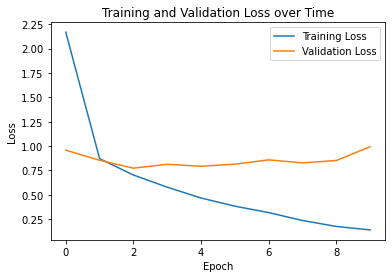

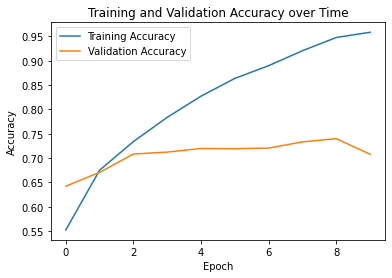

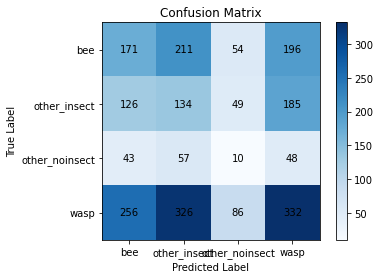

In [9]:

helpers_01.evaluate_model(X_train, X_test, model, history)


## 7. View training metrics in TensorBoard

Now that we've run one training cycle, we can open TensorBoard and have a look at the visualizations it provides to evaluate training performance.

The detailed instructions for different platforms are in the course content. In general, we use the `tensorboard --logdir ./logs` command to start TensorBoard and then connect in a Web browser. Here's a screenshot of what that might look like:

![Screenshot of the TensorBoard web page](images/tensorboard_screenshot.png)



## 7. Explore hyperparameters!

OK, we've trained the model once using some decent first guesses. Now, we can see if we can do better by exploring different hyperparameters.

While there are methods to explore different hyperparameters systematically and track the results more efficiently, we will rely on some ad-hoc exploration and keep everything in the notebook.

The following function pulls all the steps from above into a single function.

In [15]:
def the_whole_shebang(path, batch_size, shape, classes, activation, loss, optimizer, show_pictures=True):
    
    X_train, X_test = helpers_01.load_display_data(data_path, batch_size, shape, show_pictures)
    model = make_model(activation=activation, shape=shape, num_classes=classes)
    model, history = helpers_01.compile_train_model(X_train, X_test, model, loss=loss,
                        optimizer=optimizer, learning_rate=learning_rate, epochs=epochs)
    helpers_01.evaluate_model(X_train, X_test, model, history, classes)

### Copy the next cell and change hyperparameters

You can copy the next cell multiple times and adjust the hyperparameters to compare results.

***********************************************************************
Load data:
  - Loading the dataset from: /blue/practicum-ai/share/data/bee_vs_wasp.
  - Using a batch size of: 32.
  - Resizing input images to: (80, 80, 3).
***********************************************************************
Found 11422 files belonging to 4 classes.
Using 9138 files for training.
Found 11422 files belonging to 4 classes.
Using 2284 files for validation.
['bee', 'other_insect', 'other_noinsect', 'wasp']


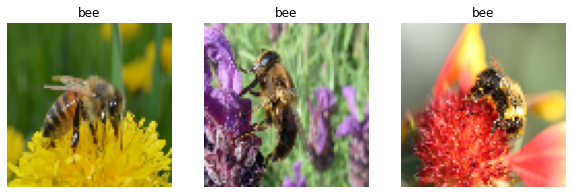

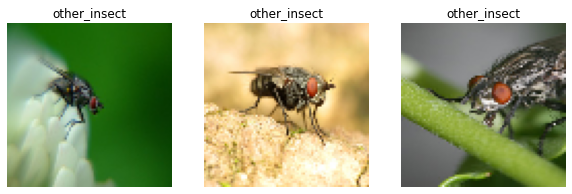

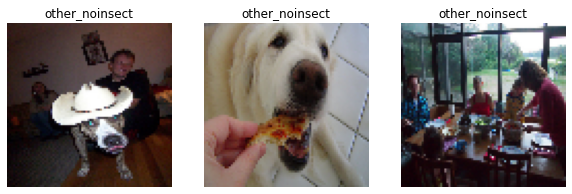

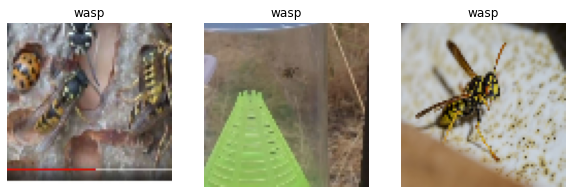

***********************************************************************
Make model:
  - Using the activation function: relu.
  - Model will have 4 classes.
***********************************************************************
***********************************************************************
Compile and Train the model:
  - Using the loss function: <keras.losses.SparseCategoricalCrossentropy object at 0x1495c00a6790>.
  - Using the optimizer: Adagrad.
  - Using learning rate of: 0.001.
  - Running for 10 epochs.
  - Using these callbacks: []
***********************************************************************
Epoch 1/10


/apps/tensorflow/2.7.0/lib/python3.9/site-packages/tensorflow/python/util/dispatch.py:1096: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


286/286 [==============================] - 8s 26ms/step - loss: 2.2581 - accuracy: 0.5658 - val_loss: 1.0737 - val_accuracy: 0.6165
Epoch 2/10
286/286 [==============================] - 8s 28ms/step - loss: 0.8549 - accuracy: 0.6710 - val_loss: 0.9195 - val_accuracy: 0.6607
Epoch 3/10
286/286 [==============================] - 8s 28ms/step - loss: 0.7431 - accuracy: 0.7110 - val_loss: 0.8534 - val_accuracy: 0.6699
Epoch 4/10
286/286 [==============================] - 8s 26ms/step - loss: 0.6647 - accuracy: 0.7402 - val_loss: 1.0023 - val_accuracy: 0.6366
Epoch 5/10
286/286 [==============================] - 7s 25ms/step - loss: 0.6077 - accuracy: 0.7693 - val_loss: 0.8274 - val_accuracy: 0.6791
Epoch 6/10
286/286 [==============================] - 8s 28ms/step - loss: 0.5558 - accuracy: 0.7937 - val_loss: 0.8719 - val_accuracy: 0.6703
Epoch 7/10
286/286 [==============================] - 8s 27ms/step - loss: 0.5114 - accuracy: 0.8074 - val_loss: 0.8353 - val_accuracy: 0.6865
Epoch 8/10

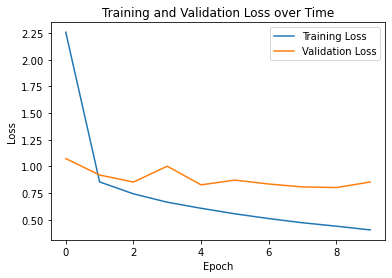

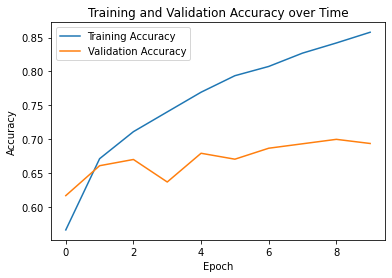

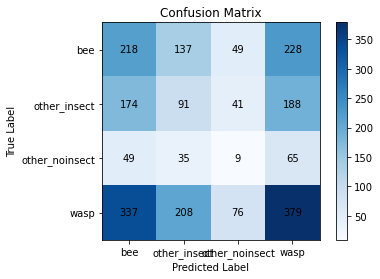

In [16]:
#data_path = 'data/bee_vs_wasp/' # Path to the data.
        # This is defined above, you only need to change this if you change datasets
    
show_pictures = True # Show sample images from the dataset? Keep on at first, but may become distracting.
                     # Set to False to turn off

# Hyperparameters
shape = (80,80,3)  # Dimensions to use for the images...the raw data are 80x80
                   #  color images, but you could down-sample them
                   #  or convert them to black and white if you wanted
batch_size = 32  # What batch size to use
classes = 4 # We have 4 classes in our dataset: bee, wasp, other_insect, other_noninsect
            # Only change this if you change the dataset
activation='relu' # The activation function is an important hyperparameter
                  # Other activations functions to try: tanh, sigmoid

loss=SparseCategoricalCrossentropy(from_logits=True) # Loss function
        # Other loss functions to try: losses.CategoricalHinge()
        #                              losses.KLDivergence()

optimizer='Adagrad' # Optimizer: Adagrad is just an example, others to try are Adam or RMSprop

learning_rate=0.001 # Try increasing or decreasing the learning rate by an order of magnitude

epochs = 10 # Try running more epochs

# Run everything with these hyperparameters
the_whole_shebang(data_path, batch_size, shape, classes, activation, loss, optimizer, show_pictures)

## 8. A look inside CNNs
To get an idea for what is happening *inside* this model, let's look at a **feature map**. Below we see a vertical edge detection filter applied to a sunflower picture, resulting in a feature map of that image.

![Two pictures of a sunflower. On the left is the original image, on the right is the convolved image resulting from applying an edge detecting convolutional filter.](images/filtered_sunflower_nb01.jpg)

Imagine you're a detective investigating a scene.  A feature map is like a sketch you create, focusing on specific details that might be clues to solving the case.  In a CNN, the "case" is recognizing patterns in an image, and the feature maps capture these patterns at different levels of complexity. Early layers might create feature maps that detect basic edges, corners, or blobs of color. As the network progresses through more layers, the feature maps become more intricate, combining these simpler features to represent more complex objects or shapes.

Getting a bit more technical, a feature map is a 2D array of activations produced by applying a convolutional filter to an input image or a previous layer's feature map. It essentially captures the presence and strength of specific visual features the filter is optimized to detect within the input.

The **convolutional filters** (also just called "filters" or "kernels") are small matrices containing learnable weights. The filter "slides" across the input image, performing element-wise multiplication with the underlying image data at each position. The result of the multiplication is then passed through an activation function (like ReLU) to introduce non-linearity and help the network learn complex features. A convolutional layer typically has multiple filters, each generating a separate feature map. These feature maps capture different aspects of the input, providing a richer representation of the image.

**NOTE**: The above sunflower example could potentially be a bit misleading. While a model *can* and probably will develop a vertical edge detection filter, the model develops it's filter's weights through the same backpropagation process as other deep neural networks. Most of the filters, and their resulting feature maps, will not be as easily interpretable as the vertical edge detection filter.

<Figure size 720x720 with 0 Axes>

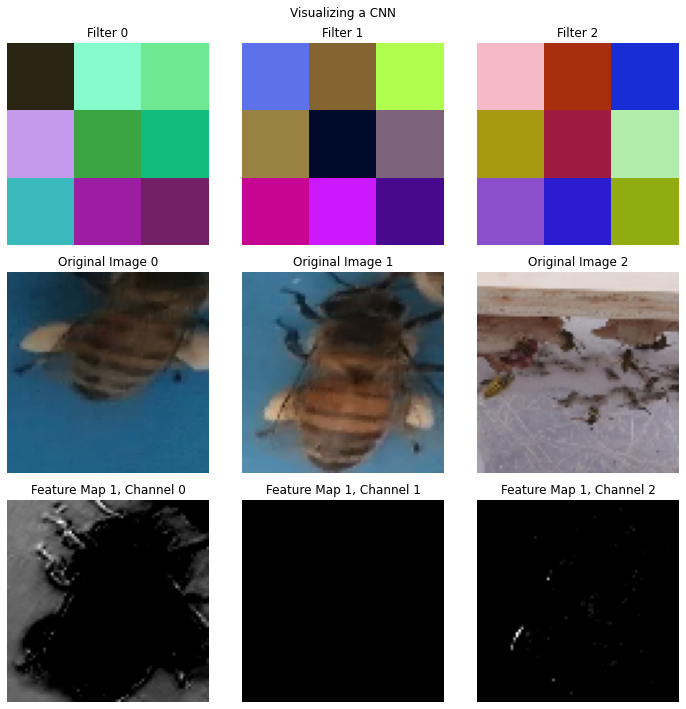

In [17]:
# Get the filters from the first layer of the model
filters = model.layers[0].get_weights()[0]

# Get the first batch of images from the training set
conv_images = X_train.take(1)
plt.figure(figsize=(10, 10))
for images, labels in conv_images:
    images = images.numpy()
    labels = labels.numpy()

# Get the feature maps from the first layer of the model
feature_maps = tf.keras.models.Model(inputs=model.inputs, outputs=model.layers[0].output)
feature_maps = feature_maps.predict(images)

# Normalize the filters and feature maps. This will make the images more clear.
normal_filters = (filters - filters.min()) / (filters.max() - filters.min())
normal_feature_maps = (feature_maps - feature_maps.min()) / (feature_maps.max() - feature_maps.min())

# Display the filters, images and feature maps
plt.figure(figsize=(10, 10))

# ----- Filters -----
for i in range(3):
    plt.subplot(3, 3, i + 1)  # 3 rows, 3 columns, position 1 to 3 
    plt.imshow(normal_filters[:, :, :, i], cmap='gray')
    plt.title(f'Filter {i}')
    plt.axis('off')

# ----- Original Images -----
for i in range(3):
    plt.subplot(3, 3, i + 4)  # Position 4 to 6
    plt.imshow(images[i].astype("uint8"))
    plt.title(f'Original Image {i}')
    plt.axis('off')

# -----  Feature Maps (Image 1) -----
for i in range(3):
    plt.subplot(3, 3, i + 7)  # Position 7 to 9
    plt.imshow(normal_feature_maps[1, :, :, i], cmap='gray')
    plt.title(f'Feature Map 1, Channel {i}')
    plt.axis('off')

plt.suptitle('Visualizing a CNN')  # Overall title for the plot
plt.tight_layout()  # Adjust spacing to prevent overlaps
plt.show()


Just as with the other hyperparameters in Section 7 above, the number of filters, the size of the filters, and the stride of the filters are all hyperparameters that can be adjusted. You can also add or remove convolutional and pooling layers, or add dropout layers. Dropout layers are a regularization technique that helps prevent overfitting by randomly setting a fraction of input units to 0 at each update during training. Here is an example of how to add a dropout layer to the model:
    
```python
    # Import the Dropout layer
    from tensorflow.keras.layers import Dropout

    # Existing Conv2D layer
    # Dropout layer with a 50% dropout rate
    model.add(Dropout(0.5)) 
    # Existing MaxPooling2D layer
```
To adjust the stride and padding of the convolutional layers, you can add the `strides` and `padding` arguments to the `Conv2D` layer. The `strides` argument is a tuple of two integers, specifying the strides of the convolution along the height and width. The `padding` argument can be either `'valid'` or `'same'`. `'valid'` means no padding, while `'same'` means the output feature map will have the same spatial dimensions as the input feature map. Here is an example of a convulutional layer with a stride of 2 and padding of `'same'`:
    
```python
    # Replacement Conv2D layer
    layers.Conv2D(32, (3, 3), strides=(2, 2), padding='same', activation=activation)
    # Replacement MaxPooling2D layer
    layers.MaxPooling2D((2, 2), padding='same', strides=(2, 2))
```

## 9. Conclusion
Experiment with the code in Section 4 to see how different hyperparameters and model architectures affect the model's performance. That's it. We'll see you in the next Module!

## Bonus Exercise
If you found this exercise pretty simple, try editing the code in this notebook such that our function from Section 7 (*the_whole_shebang*) can control the Dropout rate, stride, and padding of the convolutional layers.